In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)

## Phân tích EDA cho dữ liệu product trong ' order_products_prior.csv ' :
1. Tìm tên 10 sản phẩm bán được nhiều nhất và vẽ biểu đồ
2. Tìm tên 10 sản phẩm được re - ordered nhiều nhất và vẽ biểu đồ
3. Thống kê số lượng sản phẩm bán được của các department và vẽ biểu đồ
  - Biểu đồ cột
  - Biểu đồ tree - map

### 1. Tìm tên 10 sản phẩm bán được nhiều nhất và vẽ biểu đồ

+ Đọc file 'order_products__prior.csv' gồm các features: 
     order_id,	product_id,	add_to_cart_order,	reordered
+ File này gần 32 triệu dòng, nên chia dữ liệu thành các chunk (tập dữ liệu nhỏ), mỗi chunk gồm 500000 dòng

In [57]:
file_path_order = 'data/order_products__prior.csv'
N = 5e5
order_products = pd.read_csv(file_path_order, chunksize=N, usecols=['product_id','reordered'])
# Ở đây mình chỉ dùng columns ['product_id'] trong file 'order_products__prior.csv' vì mỗi lần 
# mua hàng thì đếm số lần xuất hiện của từng product
chunk = next(order_products)
chunk.head()

,product_id,reordered
0,33120,1
1,28985,1
2,9327,0
3,45918,1
4,30035,0


+ Đọc file 'products.csv' gồm các features: product_id,	product_name,	aisle_id,	department_id
+ Mục đích: để map các product_id với department_id tương ứng

In [41]:
file_path_product = 'data/products.csv'
product_info = pd.read_csv(file_path_product)
product_info.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


###### Hàm select_product(chunk):
- Truyền vô từng chunk 
- Merge từng chunk với dữ liệu product_info, dùng key là 'product_id' để map
- Đếm số lần xuất hiện của product_name

In [42]:
def select_product(chunk):
    product = product_info[['product_id','product_name']] # chỉ lấy ra thông tin
                                                    # 2 cột 'product_id','product_name'
    order_product = pd.merge(chunk,product,
                        on='product_id')['product_name'] # merge chunk với product_name thông 
                                                    # qua key 'product_id' và chỉ lấy ra cột 'product_name'
    product_count = order_product.value_counts().reset_index() # Đếm số lần xuất hiện của 'product_name'
    product_count.columns = ['product_name','counts']
    return product_count

total_product_count = select_product(chunk)

In [43]:
# for loop lặp qua từng chunk của order_products (file 32 triệu dòng)
# và concat với lại biến trả về của hàm select_product
for i,chunk in enumerate(order_products):
    chunk_count =  select_product(chunk)
    total_product_count = pd.concat([total_product_count,chunk_count])
total_product_count.shape

(1893779, 2)

In [34]:
total_product_count.head()

,product_name,counts
0,Banana,7365
1,Bag of Organic Bananas,5920
2,Organic Strawberries,4023
3,Organic Baby Spinach,3797
4,Organic Hass Avocado,3317


In [21]:
total_product_count = total_product_count.groupby('product_name').sum().reset_index()
print(total_product_count.shape)
total_product_count.head()

(49677, 2)


,product_name,counts
0,#2 Coffee Filters,777
1,#2 Cone White Coffee Filters,13
2,#2 Mechanical Pencils,8
3,#4 Natural Brown Coffee Filters,241
4,& Go! Hazelnut Spread + Pretzel Sticks,164


In [22]:
top10_sel_product = total_product_count.nlargest(10,
                                          columns='counts')
top10_sel_product

,product_name,counts
3676,Banana,472565
3471,Bag of Organic Bananas,379450
31920,Organic Strawberries,264683
28840,Organic Baby Spinach,241921
30297,Organic Hass Avocado,213584
28804,Organic Avocado,176815
22413,Large Lemon,152657
42904,Strawberries,142951
23420,Limes,140627
32478,Organic Whole Milk,137905


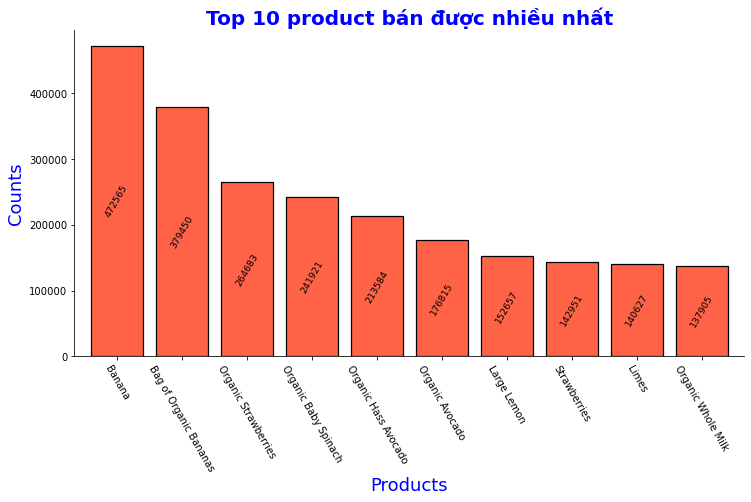

In [27]:
ax = top10_sel_product.plot.bar(x='product_name', y='counts', width=0.8, figsize=(12,6), 
                           color='tomato', legend=None, rot=-60,
                               edgecolor = 'black',linewidth = 1.25)
ax.bar_label(container=ax.containers[0], label_type='center', fontsize=9.5, rotation=60)
ax.set_title('Top 10 products bán được nhiều nhất',fontsize=20,color='blue',weight='bold')
ax.set_xlabel('Products',fontsize=18,color='blue')
ax.set_ylabel('Counts',fontsize=18,color='blue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
plt.close()

### 2. Tìm tên 10 sản phẩm được re - ordered nhiều nhất và vẽ biểu đồ
+ Tương tự như bài 1 nhưng lần này ta sẽ lọc reordered dựa trên product_id

In [72]:
file_path_order = 'data/order_products__prior.csv'
N = 5e5
order_products = pd.read_csv(file_path_order, chunksize=N, usecols=['product_id','reordered'])
# Ở đây mình chỉ dùng columns ['product_id'] trong file 'order_products__prior.csv' vì mỗi lần 
# mua hàng thì đếm số lần xuất hiện của từng product
chunk = next(order_products)
chunk.head()

,product_id,reordered
0,33120,1
1,28985,1
2,9327,0
3,45918,1
4,30035,0


In [73]:
def select_product(chunk):
    product = product_info[['product_id','product_name']]
    order_product = pd.merge(chunk,product, on='product_id')
    return order_product
total_product_count = select_product(chunk)
total_product_count.shape

(500000, 3)

In [74]:
for i,chunk in enumerate(order_products):
    chunk_count =  select_product(chunk)
    total_product_count = pd.concat([total_product_count,chunk_count])
total_product_count.shape

(32434489, 3)

In [75]:
total_product_count.drop(['product_id'], axis=1, inplace=True)
total_product_count.head()

,reordered,product_name
0,1,Organic Egg Whites
1,0,Organic Egg Whites
2,0,Organic Egg Whites
3,1,Organic Egg Whites
4,1,Organic Egg Whites


In [76]:
total_product_count = total_product_count[total_product_count['reordered']==1]
total_product_count = total_product_count.groupby('product_name').sum().reset_index()
total_product_count.shape

(45305, 2)

In [78]:
total_product_count.head()

,product_name,reordered
0,#2 Coffee Filters,257
1,#2 Cone White Coffee Filters,3
2,#4 Natural Brown Coffee Filters,89
3,& Go! Hazelnut Spread + Pretzel Sticks,87
4,(70% Juice!) Mountain Raspberry Juice Squeeze,16


In [79]:
top_10reorderd = total_product_count.nlargest(10,'reordered')
top_10reorderd

,product_name,reordered
3247,Banana,398609
3058,Bag of Organic Bananas,315913
29079,Organic Strawberries,205845
26151,Organic Baby Spinach,186884
27532,Organic Hass Avocado,170131
26116,Organic Avocado,134044
29597,Organic Whole Milk,114510
20302,Large Lemon,106255
28550,Organic Raspberries,105409
39135,Strawberries,99802


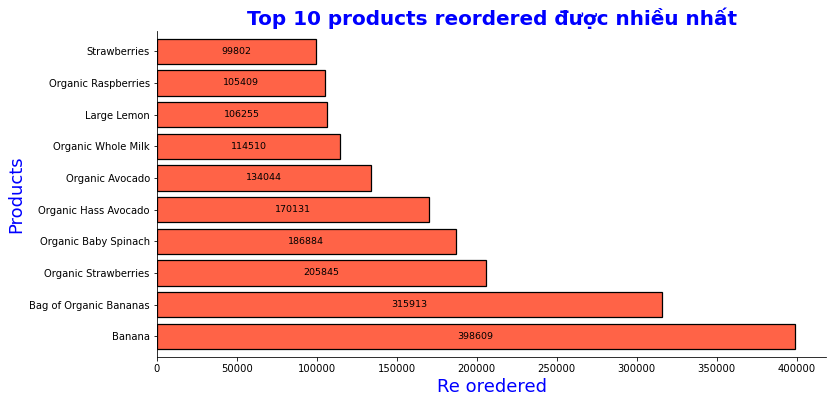

In [91]:
ax = top_10reorderd.plot.barh(x='product_name', y='reordered', width=0.8, figsize=(12,6), 
                           color='tomato', legend=None, rot=0,
                               edgecolor = 'black',linewidth = 1.25)
ax.bar_label(container=ax.containers[0], label_type='center', fontsize=9.5, rotation=0)
ax.set_title('Top 10 products reordered được nhiều nhất',fontsize=20,color='blue',weight='bold')
ax.set_xlabel('Re oredered',fontsize=18,color='blue')
ax.set_ylabel('Products',fontsize=18,color='blue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
plt.close()

### 3.Thống kê số lượng sản phẩm bán được của các department và vẽ biểu đồ
+ Biểu đồ cột
+ Biểu đồ tree - map

In [92]:
file_path_order = 'data/order_products__prior.csv'
N = 5e5
order_products = pd.read_csv(file_path_order, chunksize=N, usecols=['product_id'])
# Ở đây mình chỉ dùng columns ['product_id'] trong file 'order_products__prior.csv' vì mỗi lần 
# mua hàng thì đếm số lần xuất hiện của từng product
chunk = next(order_products)
chunk.head()

,product_id
0,33120
1,28985
2,9327
3,45918
4,30035


In [93]:
file_path_product = 'data/products.csv'
product_info = pd.read_csv(file_path_product)
product_info.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [94]:
def select_depID(chunk):
    product_dep_id = product_info[['product_id','department_id']] # chỉ lấy ra thông tin
                                                    # 2 cột 'product_id','department_id'
    order_dep = pd.merge(chunk,product_dep_id,
                        on='product_id')['department_id'] # merge chunk với product_dep_id thông 
                                                    # qua key 'product_id' và chỉ lấy ra cột 'department_id'
    dep_count = order_dep.value_counts().reset_index() # Đếm số lần xuất hiện của 'department_id'
    dep_count.columns = ['department_id','counts']
    return dep_count

total_dep_count = select_depID(chunk)

# for loop lặp qua từng chunk của order_products (file 32 triệu dòng)
# và concat với lại biến trả về của hàm select_depID
for i,chunk in enumerate(order_products):
    chunk_count =  select_depID(chunk)
    total_dep_count = pd.concat([total_dep_count,chunk_count])
total_dep_count.shape

(1365, 2)

In [95]:
total_dep_count = total_dep_count.groupby('department_id').sum().reset_index()

In [96]:
top10_sel_depID = total_dep_count.nlargest(10,
                                          columns='counts')
top10_sel_depID

,department_id,counts
3,4,9479291
15,16,5414016
18,19,2887550
6,7,2690129
0,1,2236432
12,13,1875577
2,3,1176787
14,15,1068058
19,20,1051249
8,9,866627


In [97]:
file_name_dep = 'data/departments.csv' # file chứa tên của department
dep_info = pd.read_csv(file_name_dep)
dep_info.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [98]:
top10_sel_depName = pd.merge(top10_sel_depID, dep_info,
                            on='department_id') # merge tên department theo department_id
top10_sel_depName

,department_id,counts,department
0,4,9479291,produce
1,16,5414016,dairy eggs
2,19,2887550,snacks
3,7,2690129,beverages
4,1,2236432,frozen
5,13,1875577,pantry
6,3,1176787,bakery
7,15,1068058,canned goods
8,20,1051249,deli
9,9,866627,dry goods pasta


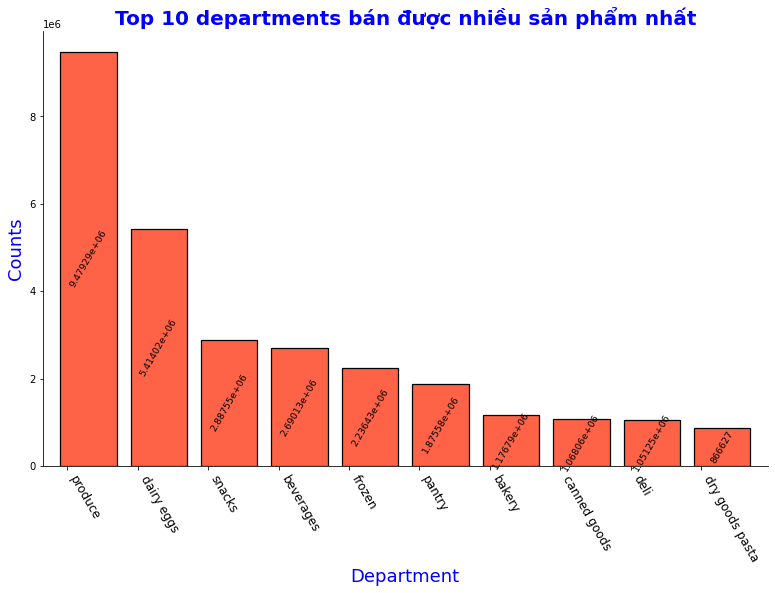

In [99]:
ax = top10_sel_depName.plot.bar(x='department', y='counts', width=0.8, figsize=(13,8), 
                           color='tomato', legend=None, rot=-60,
                               edgecolor = 'black',linewidth = 1.25)
ax.bar_label(container=ax.containers[0], label_type='center', fontsize=9.5, rotation=60)
ax.set_title('Top 10 departments bán được nhiều sản phẩm nhất',fontsize=20,color='blue',weight='bold')
ax.set_xlabel('Department',fontsize=18,color='blue')
ax.set_ylabel('Counts',fontsize=18,color='blue')
ax.set_xticks(top10_sel_depName.index-0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(top10_sel_depName['department'], ha='left',fontsize=12)
plt.show()
plt.close()

In [100]:
N = 10 
top_sel_depID = total_dep_count.nlargest(N, columns='counts')
top_sel_depName = pd.merge(top10_sel_depID, dep_info,
                            on='department_id') # merge tên department theo department_id

In [101]:
other_dep_count = total_dep_count.nsmallest(len(total_dep_count)-N,columns='counts')
sum_other_dep = other_dep_count['counts'].sum()
df_other_dep = pd.DataFrame(data=[[sum_other_dep,'others']], columns=['counts','department'],)

total_dep = top_sel_depName.copy()
total_dep.pop('department_id')
total_dep = pd.concat([total_dep, df_other_dep]).reset_index(drop=True)
total_dep

,counts,department
0,9479291,produce
1,5414016,dairy eggs
2,2887550,snacks
3,2690129,beverages
4,2236432,frozen
5,1875577,pantry
6,1176787,bakery
7,1068058,canned goods
8,1051249,deli
9,866627,dry goods pasta


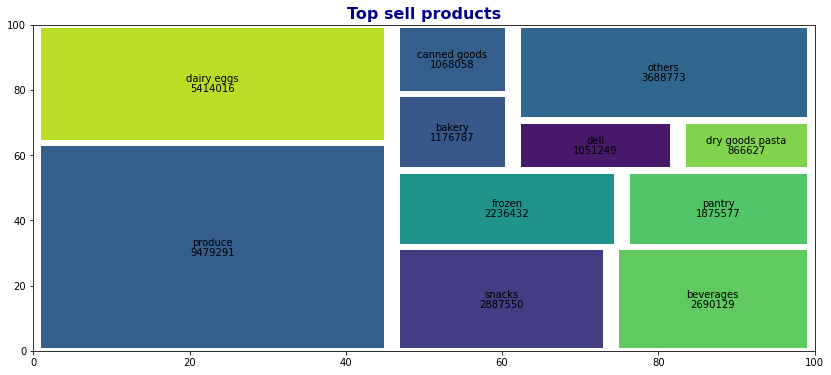

In [102]:
import squarify
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.set_title('Top sell products', fontsize=16, weight='bold',color='darkblue')
squarify.plot(sizes=total_dep['counts'],label=total_dep['department'],ax=ax,pad=True,
             value=total_dep['counts'])
plt.show()